## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
MAX_SEQUENCE_LENGTH_T = 20 # 40
MAX_SEQUENCE_LENGTH_D = 200 # 200
MAX_SEQUENCE_LENGTH_I = 1682
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [6]:
DIR = 'data/processed/eclipse'
DATASET = os.path.join('data/normalized/eclipse', 'eclipse.csv')
DIR_PAIRS = 'data/normalized/eclipse'

In [7]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [8]:
baseline.info_dict

{'bug_severity': 7,
 'bug_status': 3,
 'component': 927,
 'priority': 5,
 'product': 189,
 'version': 551}

In [9]:
"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
name = 'baseline_1000epoch_10steps_1024batch(eclipse)'

similarity_model = Baseline.load_model('', name, {'l2_normalize' : Baseline.l2_normalize})

Loaded model from disk


#### Loading bug ids in memory

In [10]:
baseline.load_ids(DIR)

#### Generating tiple of batches

In [11]:
%%time

baseline.prepare_dataset()

Reading train data
Reading the test...


12798it [00:00, 67424.71it/s]

Reading test data
CPU times: user 444 ms, sys: 9.02 ms, total: 453 ms
Wall time: 448 ms


#### Loading train bugs

In [12]:
baseline.load_bugs()

100%|██████████| 212512/212512 [00:10<00:00, 20464.40it/s]


## Siamese  model

In [13]:
## Freeze weights
# for layer in similarity_model.layers:
#     layer.trainable = False

In [14]:
from keras.layers import concatenate, Dropout, Add

bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder(bug_t_a)
bugt_d_a = desc_encoder(bug_d_a)
bugt_i_a = info_encoder(bug_i_a)
# Bug B
bugt_t_b = title_encoder(bug_t_b)
bugt_d_b = desc_encoder(bug_d_b)
bugt_i_b = info_encoder(bug_i_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(256)(x)
    #x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a, bug_t_b, bug_d_a, bug_d_b, bug_i_a, bug_i_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 1682)         0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 200)          0                                            
__________________________________________________________________________________________________
info_b (InputLayer)             (None, 1682)         0                                            
__________________________________________________________________________________________________
title_b (I

In [15]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    input_sample, input_pos, input_neg, sim = baseline.batch_iterator(train, dup_sets, batch_size_normalized, n_neg)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, n_neg)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [16]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [17]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 1), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
                                             callbacks=[early],
                                             verbose = True) 

Epoch 1/100
10/10 [==============================] - 8s 795ms/step - loss: 1.0467 - acc: 0.5644 - val_loss: 1.6467 - val_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 3s 334ms/step - loss: 0.6658 - acc: 0.6369 - val_loss: 0.7212 - val_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 3s 322ms/step - loss: 0.6173 - acc: 0.6753 - val_loss: 0.6941 - val_acc: 0.5000
Epoch 4/100
10/10 [==============================] - 3s 327ms/step - loss: 0.5955 - acc: 0.6842 - val_loss: 0.7204 - val_acc: 0.5000
Epoch 5/100
10/10 [==============================] - 3s 321ms/step - loss: 0.6065 - acc: 0.6749 - val_loss: 0.7115 - val_acc: 0.5000
Epoch 6/100
10/10 [==============================] - 3s 340ms/step - loss: 0.5959 - acc: 0.6889 - val_loss: 0.6987 - val_acc: 0.5000
Epoch 7/100
10/10 [==============================] - 3s 321ms/step - loss: 0.5939 - acc: 0.6844 - val_loss: 0.7223 - val_acc: 0.5000
Epoch 8/100
10/10 [==============================] - 3s 329ms/step - 

10/10 [==============================] - 3s 328ms/step - loss: 0.3612 - acc: 0.8418 - val_loss: 0.4539 - val_acc: 0.7734
Epoch 63/100
10/10 [==============================] - 3s 336ms/step - loss: 0.3526 - acc: 0.8490 - val_loss: 0.4542 - val_acc: 0.7949
Epoch 64/100
10/10 [==============================] - 3s 331ms/step - loss: 0.3601 - acc: 0.8451 - val_loss: 0.4373 - val_acc: 0.7988
Epoch 65/100
10/10 [==============================] - 3s 337ms/step - loss: 0.3590 - acc: 0.8467 - val_loss: 0.4225 - val_acc: 0.7910
Epoch 66/100
10/10 [==============================] - 3s 326ms/step - loss: 0.3564 - acc: 0.8463 - val_loss: 0.4310 - val_acc: 0.7949
Epoch 67/100
10/10 [==============================] - 3s 340ms/step - loss: 0.3393 - acc: 0.8573 - val_loss: 0.4702 - val_acc: 0.7734
Epoch 68/100
10/10 [==============================] - 3s 326ms/step - loss: 0.3420 - acc: 0.8549 - val_loss: 0.4523 - val_acc: 0.7949
Epoch 69/100
10/10 [==============================] - 3s 319ms/step - loss:

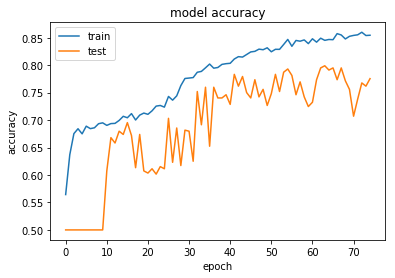

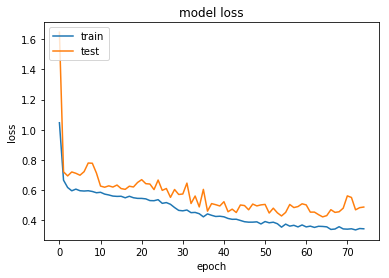

In [22]:
Baseline.validation_accuracy_loss(h_clf)

### Roc AUC/SCORE

#### train

In [31]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_auc_score(y_true, y_scores)

0.9009246826171875

#### test

In [37]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_auc_score(y_true, y_scores)

0.90496826171875

In [38]:
name = 'baseline_classification_100epoch_10steps(eclipse)'
Baseline.save_model('', model_clf, name)

Saved model to disk
